# Import

In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import seaborn as sns

import warnings
import time

from datetime import datetime, timedelta

import requests
import urllib.request
from urllib import parse
import json 
from pandas.io.json import json_normalize
from datetime import datetime

# Dataset from API

In [ ]:
# Request URL
req_url = '	http://data.ex.co.kr/openapi/odtraffic/trafficAmountByRealtime'

In [ ]:
# 인증키
key = 6730848825

## Define Functions

In [ ]:
params = {'key':key, 'type':'json'}
params_encode = parse.urlencode(params)
url = req_url + '?' + params_encode
        
response = urllib.request.urlopen(url)
json_str = response.read().decode('utf-8')
json_obj = json.loads(json_str)

In [ ]:
pd.json_normalize(json_obj['list']).shape

In [ ]:
def API_download(api_name:str, key:str, download_dir:str) -> None:
    
    total_df = pd.DataFrame()
    
    if not os.path.isdir(download_dir):
        os.makedirs(download_dir)
    
    params = {'key':key, 'type':'json'}
    params_encode = parse.urlencode(params)
    url = req_url + '?' + params_encode

    response = urllib.request.urlopen(url)
    json_str = response.read().decode('utf-8')
    json_obj = json.loads(json_str)

    #print(json_obj)

    df = pd.json_normalize(json_obj['list'])
        
    #execute_date = datetime.today().strftime("%y%m%d%H%M%S")
    
    df_day = df['stdDate'].iloc[0]
    df_hour = df['stdHour'].iloc[0]
    
    print(df_day, df_hour)
    
    file_name = f'{api_name}_{df_day}_{df_hour}.csv'
    file_dir = os.path.join(download_dir, file_name)
    
    df.to_csv(file_dir, encoding = 'cp949')
        
    return df

# RUN : Download JSON & Save to CSV

api_name = 'realtime_traffic'
download_dir = 'Dataset'

loopCount = 0

while(loopCount < 2000):

    df = API_download(api_name = api_name, key = key, download_dir = download_dir)

    time.sleep(110)
    loopCount = loopCount + 1
    
    #print(df.head(3))

# Data

In [24]:
file_dir = os.path.join('D:/OneDrive - 연세대학교 (Yonsei University)/Lectures/Github/traffic_engineering/raws')
file_list = os.listdir(file_dir)[:-1]

In [25]:
file_list

['VDS_16_04_01_310159.csv',
 'VDS_16_04_01_546952.csv',
 'VDS_16_04_01_548905.csv',
 'VDS_16_04_01_557359.csv']

In [71]:
conzone = '안성IC-북천안IC'
VDS_ID = ['0010VDS26900', '0010VDS27000', '0010VDE27100', '0010VDS27200', '0010VDS27300', '0010VDS27400', '0010VDS27500']

In [72]:
vds = pd.DataFrame()

for file in tqdm(file_list):
    file_path = os.path.join(file_dir, file)
    df = pd.read_csv(file_path, encoding = 'cp949')
    
    df = df[df['VDS_ID'].isin(VDS_ID) == True]
    
    vds = pd.concat([vds, df])

save_path = os.path.join(file_dir, 'vds_save.csv')
vds.to_csv(save_path, encoding = 'cp949')

vds_origin = vds.copy()

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [05:57<00:00, 89.33s/it]


# 저장된 파일 불러와서 플로팅하기

## 파일 불러오기

In [79]:
file_dir = os.path.join('D:/OneDrive - 연세대학교 (Yonsei University)/Lectures/Github/traffic_engineering/raws')
file_path = os.path.join(file_dir, 'vds_save.csv')

In [80]:
vds = pd.read_csv(file_path, encoding = 'cp949')

## 데이터 스크리닝

In [5]:
def timecol(x):
    """수집시분초 컬럼을 시/분/초문자열로 쪼개기"""
    
    x = str(x)
    
    if len(x) == 6:
        pass
        
    elif len(x) == 5:
        x = '0' + x
        
    elif len(x) == 4:
        x = '00' + x
        
    elif len(x) == 3:
        x = '000' + x
        
    elif len(x) == 2:
        x = '0000' + x
    
    elif len(x) == 1:
        x = '00000' + x
        
    else:
        pass
    
    hour = x[:2]
    minute = x[2:4]
    second = x[4:]
    
    return hour, minute, second

In [6]:
def flr(x):
    
    x = np.floor(x)
    
    return x

## 플로팅

In [217]:
warnings.filterwarnings('ignore')

vds_id = '0010VDS27000'

vds2 = vds[(vds['평균속도'] != 0) & (vds['평균속도'] != -1) & (vds['점유율'] != -1) & (vds['교통량'] != -1) & (vds['차로번호'] == 2) & (vds['VDS_ID'] == vds_id)]
vds2['시'], vds2['분'], vds2['초'] = zip(*vds2.apply(lambda x: timecol(x.수집시분초), axis = 1))
vds2['교통류율'] = vds2['교통량'] * 120 # 1시간 환산 교통류율
vds2['평균속도x교통량'] = vds2['평균속도'] * vds2['교통량']

vds2.head(3)

,Unnamed: 0,수집일자,수집시분초,VDS_ID,지점이정,도로이정,점유율,평균속도,교통량,차로번호,콘존ID,콘존명,콘존길이,Unnamed: 12,시,분,초,교통류율,평균속도x교통량
16,6440,20230225,0,0010VDS27000,351.1,360.11,7.0,95.0,7.0,2,0010CZS385,안성IC-북천안IC,11.6,NaN,00,00,00,840.0,665.0
46,6672,20230225,13430,0010VDS27000,351.1,360.11,2.0,78.0,2.0,2,0010CZS385,안성IC-북천안IC,11.6,NaN,01,34,30,240.0,156.0
81,25398,20230225,10130,0010VDS27000,351.1,360.11,3.0,137.0,2.0,2,0010CZS385,안성IC-북천안IC,11.6,NaN,01,01,30,240.0,274.0


# 필터링
* 도로용량편람 : 기본구간 서비스수준에 따라서 필터링하기

In [224]:
vds3 = vds2[['점유율', '평균속도', '교통류율']]
vds3.columns = ['Occupancy', 'Speed', 'Flowrate']

# # flowrate 700 이하 : LOS A인데 인데 속도가 - 이하인 경우 제거
vds3 = vds3[(vds3['Flowrate'] >= 700) | (vds3['Speed'] >= 70)]

# # flowrate 700~1150 : LOS B인데 속도가 - 이하인 경우 제거
vds3 = vds3[(vds3['Flowrate'] >= 1150) | (vds3['Speed'] >= 60)]

# # flowrate 1150~1500 : LOS C 인데 속도가 - 이하인 경우 제거
vds3 = vds3[(vds3['Flowrate'] >= 1500) | (vds3['Speed'] >= 50)]

# # flowrate 1500~1900 : LOS D
vds3 = vds3[(vds3['Flowrate'] >= 1900) | (vds3['Speed'] >= 40)]

# # flowrate 1900~ : LOS E, F


# 플로팅

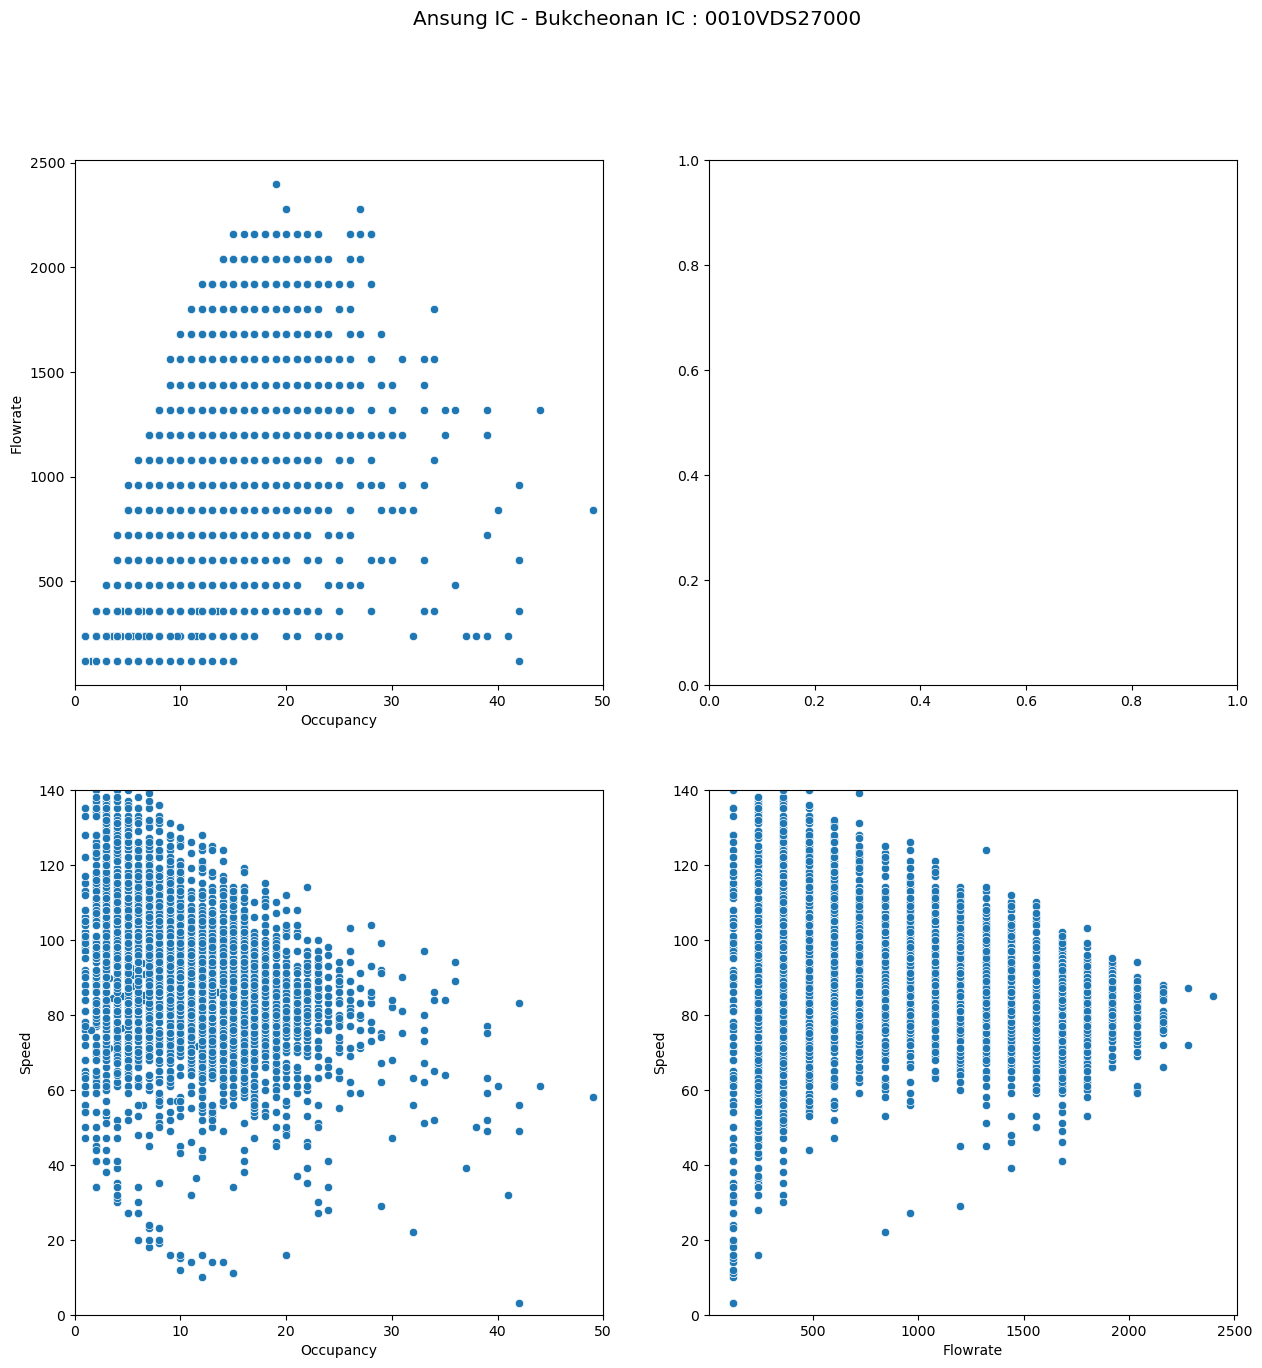

In [220]:
# 그래프 그리기
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 15))

fig.suptitle(f'Ansung IC - Bukcheonan IC : {vds_id}', fontsize="x-large")

sns.scatterplot(x = 'Occupancy', y = 'Flowrate', data = vds3, ax = ax[0][0])
sns.scatterplot(x = 'Occupancy', y = 'Speed', data = vds3, ax = ax[1][0])
sns.scatterplot(x = 'Flowrate', y = 'Speed', data = vds3, ax = ax[1][1])

#ax[0][0].set_xticks([0, 10, 20, 30, 40, 50])
ax[0][0].set_xlim([0, 50])
#ax.set_yticks([-2, 0, 2])

#ax[1][0].set_xticks([0, 10, 20, 30, 40, 50])
ax[1][0].set_xlim([0, 50])


ax[1][0].set(ylim = (0, 140))
ax[1][1].set(ylim = (0, 140))

fig.savefig('Scatterplot_full.png')

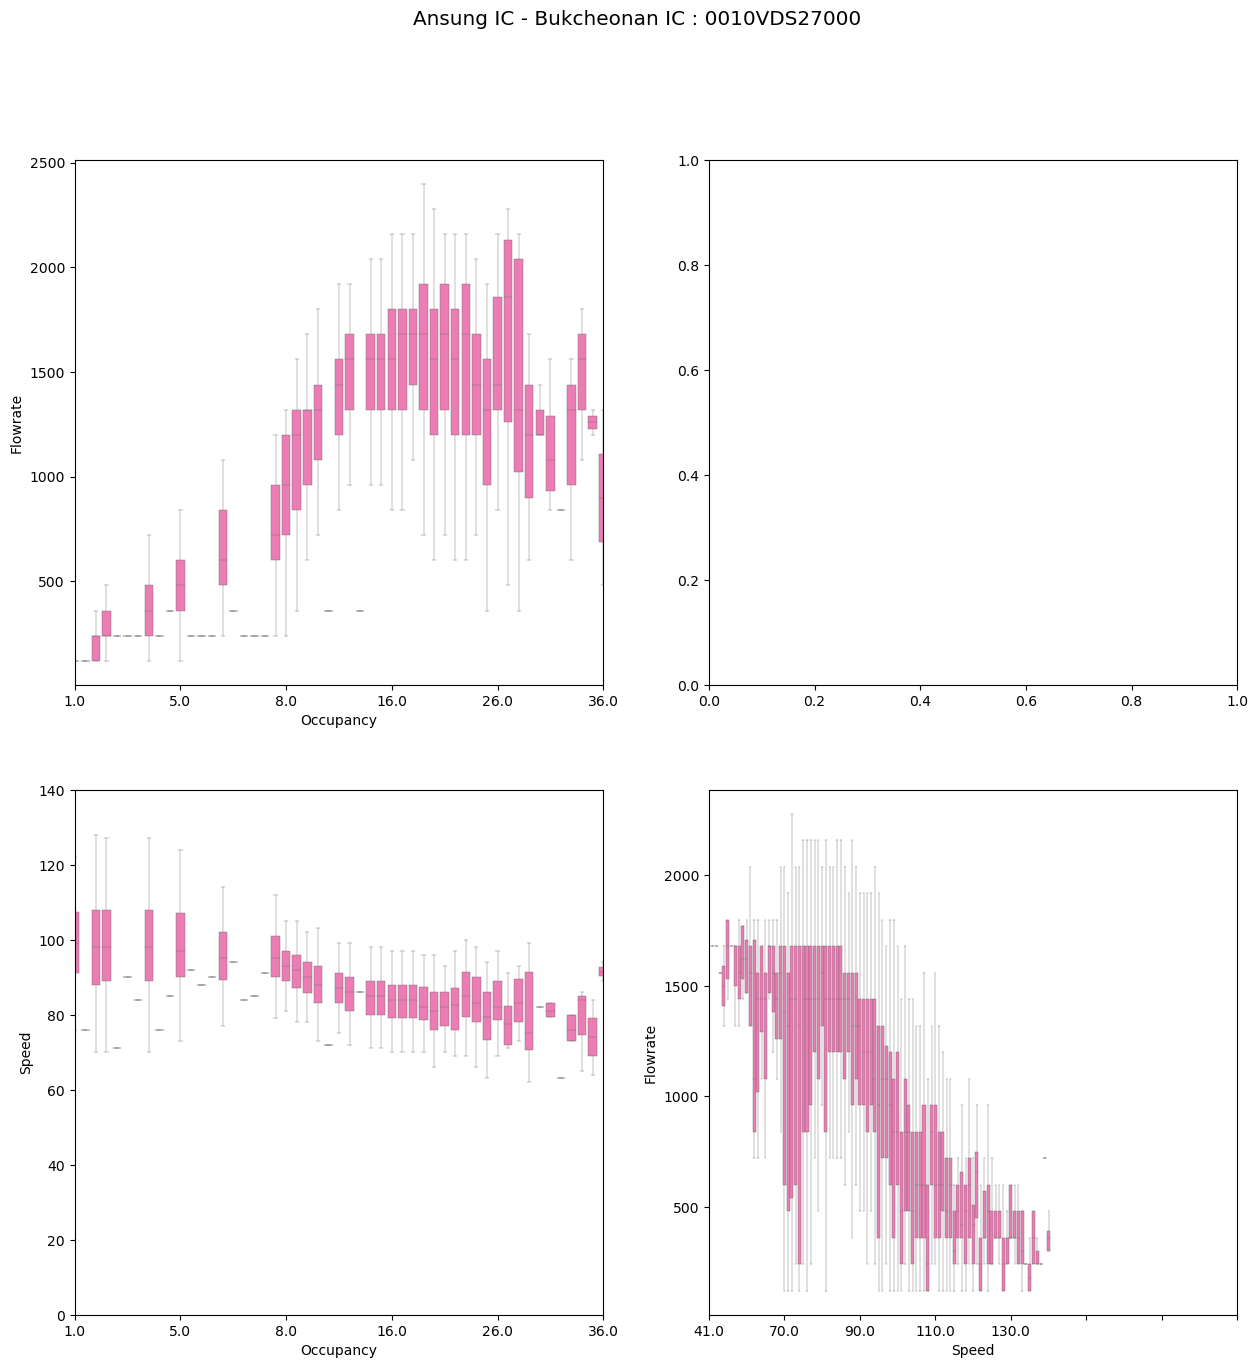

In [209]:
# 그래프 그리기
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 15))

fig.suptitle(f'Ansung IC - Bukcheonan IC : {vds_id}', fontsize="x-large")

sns.boxplot(x = 'Occupancy', y = 'Flowrate', data = vds3, dodge = False, ax = ax[0][0], showfliers = False, color = 'hotpink', whis = 1, linewidth = 0.3)
sns.boxplot(x = 'Occupancy', y = 'Speed', data = vds3, dodge = False, ax = ax[1][0], showfliers = False, color = 'hotpink', whis = 1, linewidth = 0.3)
sns.boxplot(x = 'Speed', y = 'Flowrate' , data = vds3, dodge = False, ax = ax[1][1], showfliers = False, color = 'hotpink', whis = 1, linewidth = 0.3)

#sns.scatterplot(x = 'Flowrate', y = 'Speed', data = vds3, ax = ax[1][1])
#sns.scatterplot(x = 'Occupancy', y = 'Flowrate', data = vds3, ax = ax[0][0])

ax[0][0].set_xticks([0, 10, 20, 30, 40, 50])
ax[0][0].set_xlim([0, 50])
#ax.set_yticks([-2, 0, 2])

ax[1][0].set_xticks([0, 10, 20, 30, 40, 50])
ax[1][0].set_xlim([0, 50])


ax[1][0].set(ylim = (0, 140))
ax[1][1].set(xlim = (0, 140), xticks = (0, 20, 40, 60, 80, 100, 120, 140))



fig.savefig('Boxplot.png')

# 실패 로그

In [225]:
occupancy_list = vds3['Occupancy'].unique()
speed_list = vds3['Speed'].unique()

# vds2의 각 점유율에 대하여 Speed quantile 0.5 이상 값들만 보이도록 데이터프레임을 만들기
es1 = pd.DataFrame()

for occu in occupancy_list:
    
    mdf = vds3[vds3['Occupancy'] == occu] # 같은 점유율
    border = np.quantile(mdf['Speed'], 0.5)
    #print(border)
    mdf = mdf[mdf['Speed'] >= border]
    
    es1 = pd.concat([es1, mdf])
    
    
#각 speed별 최대 flowrate만 고르기
es2 = pd.DataFrame()

for speed in speed_list:
    
    mdf = vds3[vds3['Speed'] == speed] # 같은 속도에서
    border = np.quantile(mdf['Flowrate'], 0.5)
    #print(border)
    mdf = mdf[mdf['Flowrate'] >= border]
    
    es2 = pd.concat([es2, mdf])

# 각 occupancy별 최대 flowrate 고르기
es3 = pd.DataFrame()

for occu in occupancy_list:
    
    mdf = vds3[vds3['Occupancy'] == occu] # 같은 점유율
    border = np.quantile(mdf['Flowrate'], 0.5)
    #print(border)
    mdf = mdf[mdf['Flowrate'] >= border]
    
    es3 = pd.concat([es3, mdf])

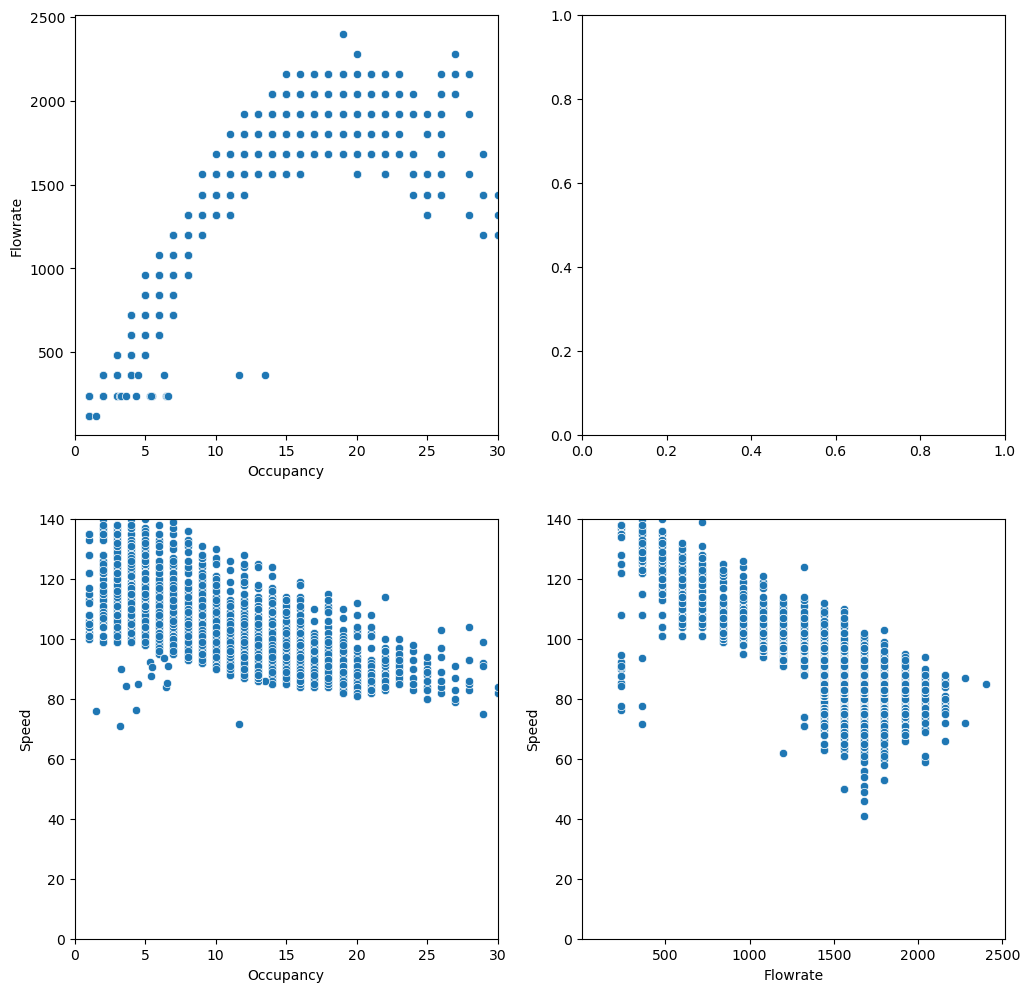

In [226]:
# 그래프 그리기
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 12))

sns.scatterplot(x = 'Occupancy', y = 'Speed', data = es1, ax = ax[1][0])
sns.scatterplot(x = 'Flowrate', y = 'Speed', data = es2, ax = ax[1][1])
sns.scatterplot(x = 'Occupancy', y = 'Flowrate', data = es3, ax = ax[0][0])

ax[0][0].set_xlim([0, 30])
ax[1][0].set_xlim([0, 30])
ax[1][0].set_ylim([0, 140])
ax[1][1].set_ylim([0, 140])

fig.savefig('Scatterplot_50p.png')

In [38]:
df = pd.pivot_table(vds2,   
                    index = ['수집일자','수집시분초'],
                    #columns = ['',    # 열 위치에 들어갈 열
                    values = ['평균속도x교통량', '교통량', '교통류율', '점유율'],     # 데이터로 사용할 열
                    aggfunc = {'평균속도x교통량' : 'sum', '교통량' : 'sum', '교통류율' :  'mean', '점유율' : 'mean'})   # 데이터 집계함수

df['평균속도'] = df['평균속도x교통량']/df['교통량']

In [41]:
df.columns = ['Volume', 'Flowrate', 'Occupancy', 'xx', 'Speed']
df.head(5)

Volume  Flowrate  Occupancy     xx  Speed
수집일자     수집시분초                                           
20230222 0         1.0     120.0        1.0  101.0  101.0
         30        2.0     240.0        2.0  240.0  120.0
         100       4.0     480.0        5.0  428.0  107.0
         130       4.0     480.0        3.0  456.0  114.0
         300       3.0     360.0        5.0  306.0  102.0

In [9]:
# 각 점유율별 Speed의 최고값만 고르기

pv1 = pd.pivot_table(df,   
                    index = ['VDS_ID', 'Occupancy'],
                    #columns = ['',    # 열 위치에 들어갈 열
                    values = ['Speed'],     # 데이터로 사용할 열
                    aggfunc = 'max')   # 데이터 집계함수

#각 speed별 최대 flowrate만 고르기
pv2 = pd.pivot_table(df,   
                    index = ['VDS_ID', 'Speed'],
                    #columns = ['',    # 열 위치에 들어갈 열
                    values = ['Flowrate'],     # 데이터로 사용할 열
                    aggfunc = 'max')   # 데이터 집계함수

# 각 occupancy별 최대 flowrate 고르기
pv3 = pd.pivot_table(df,   
                    index = ['VDS_ID', 'Occupancy'],
                    #columns = ['',    # 열 위치에 들어갈 열
                    values = ['Flowrate'],     # 데이터로 사용할 열
                    aggfunc = 'max')   # 데이터 집계함수

# 그래프 그리기
fig, ax = plt.subplots(ncols = 3, figsize = (15, 5))

sns.scatterplot(x = 'Occupancy', y = 'Speed', data = pv1, ax = ax[0])
sns.scatterplot(x = 'Flowrate', y = 'Speed', data = pv2, ax = ax[1])
sns.scatterplot(x = 'Occupancy', y = 'Flowrate', data = pv3, ax = ax[2])

ax[0].set_ylim([0, 140])
ax[1].set_ylim([0, 140])

NameError: name 'df' is not defined